Compiling model...
'compile' took 0.000406 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [3.12e+00, 2.15e+00, 4.37e-01, 4.61e-02]    [3.31e+00, 2.15e+00, 4.37e-01, 4.61e-02]    [2.45e+00]    
1000      [1.89e-01, 3.82e-01, 5.56e-03, 6.30e-02]    [1.65e-01, 3.82e-01, 5.56e-03, 6.30e-02]    [7.87e-01]    

Best model at step 1000:
  train loss: 6.40e-01
  test loss: 6.15e-01
  test metric: [7.87e-01]

'train' took 11.170120 s

Compiling model...
'compile' took 0.001377 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
1000      [1.89e-01, 3.82e-01, 5.56e-03, 6.30e-02]    [1.65e-01, 3.82e-01, 5.56e-03, 6.30e-02]    [7.87e-01]    
2000      [1.81e-03, 1.04e-01, 4.73e-03, 1.50e-01]    [1.85e-03, 1.04e-01, 4.73e-03, 1.50e-01]    [4.32e-01]    

Best model at step 2000:
  train loss: 2.60e-01
  test loss: 2.60e-

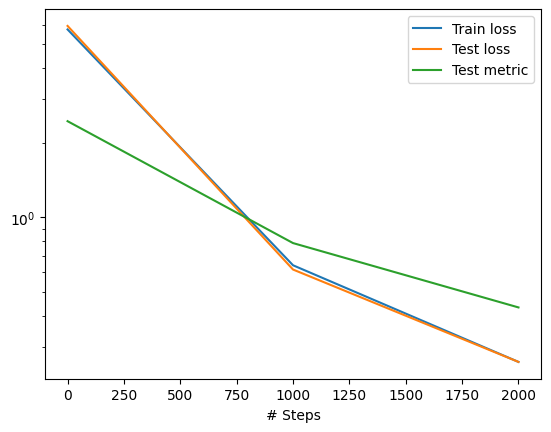

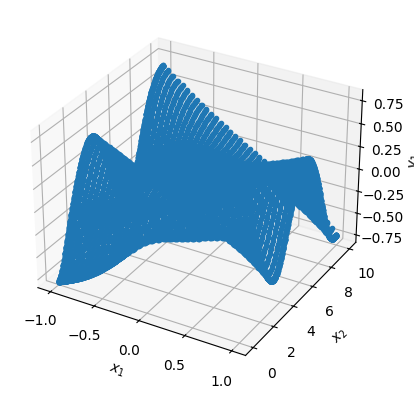

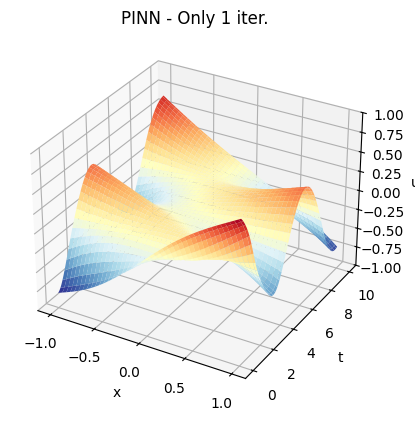

In [6]:
"""Backend supported: tensorflow.compat.v1, tensorflow, paddle"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.interpolate import griddata
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, LinearLocator

geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 10)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


# # Define sine function
# if dde.backend.backend_name in ["tensorflow.compat.v1", "tensorflow"]:
#     from deepxde.backend import tf

#     cos = tf.math.cos
# elif dde.backend.backend_name == "paddle":
#     import paddle

#     cos = paddle.cos


def pde(x, y):
    alpha, beta, gamma, k = -1, 0, 1, 2
    dy_tt = dde.grad.hessian(y, x, i=1, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    x, t = x[:, 0:1], x[:, 1:2]
    return (
        dy_tt
        + alpha * dy_xx
        + beta * y
        + gamma * (y ** k)
        + x * torch.cos(t)
        - (x ** 2) * (torch.cos(t) ** 2)
    )


def func(x):
    return x[:, 0:1] * np.cos(x[:, 1:2])


bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic_1 = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
ic_2 = dde.icbc.OperatorBC(
    geomtime,
    lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=1),
    lambda _, on_initial: on_initial,
)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic_1, ic_2],
    num_domain=30000,
    num_boundary=1500,
    num_initial=1500,
    solution=func,
    num_test=6000,
)

layer_size = [2] + [40] * 2 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile(
    "adam", lr=0.001, metrics=["l2 relative error"], decay=("inverse time", 3000, 0.9)
)
model.train(iterations=1000)
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-05,
    maxiter=100,
    maxfun=10000,
    maxls=50,
)
model.compile("L-BFGS", metrics=["l2 relative error"])
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

x = np.linspace(-1, 1, 256)
t = np.linspace(0, 10, 100)
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
prediction = model.predict(X_star, operator=None).reshape(100,256)

x = np.ravel(X).reshape(-1, 1)
t = np.ravel(T).reshape(-1, 1)

# v = griddata(X_star, prediction[:, 0], (X, T), method="cubic")

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_zlim([-1, 1])
ax.plot_surface(X, T, prediction, cmap=cm.RdYlBu_r, edgecolor='blue', linewidth=0.0003, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.title('PINN - Only 1 iter.') 
plt.savefig('PINN.png')
plt.show(fig)

# fig, ax = plt.subplots()
# ax.set_title("Results")
# ax.set_ylabel("Prediciton")
# ax.imshow(
#     v.T,
#     interpolation="nearest",
#     cmap="viridis",
#     extent=[0, 10, -1, 1],
#     origin="lower",
#     aspect="auto",
# )
# plt.show()